# Отток клиентов

Из «Бета-Банка» стали уходить клиенты, каждый месяц, немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Построим модель, которая сможет спрогнозировать, уйдёт клиент из банка в ближайшее время или нет на основании исторических данных о поведении клиентов и расторжении договоров с банком. 

При построении модели будем использовать метрики F1 и AUC-ROC.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

from time import perf_counter

data = pd.read_csv('datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В столбце 'Tenure' есть пропуски, изучим строки с пропусками.

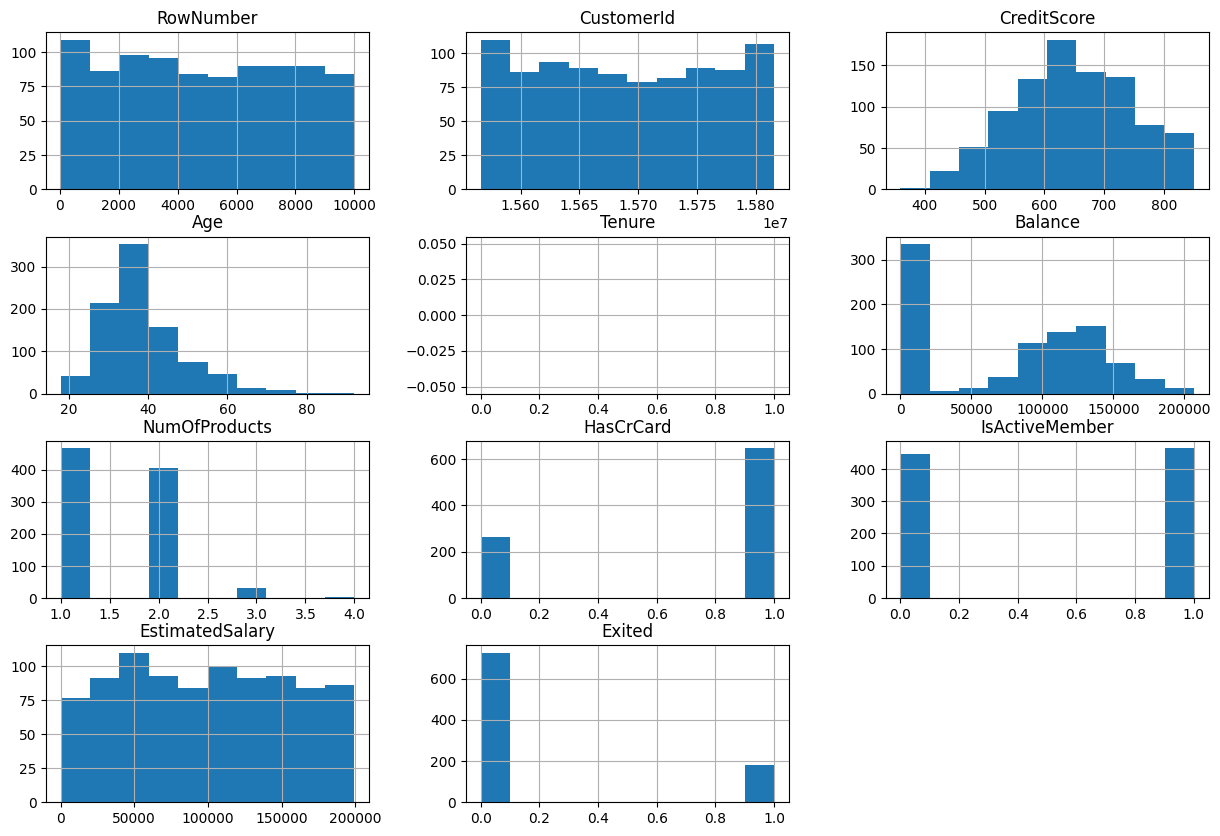

In [3]:
data[data['Tenure'].isna()].hist(figsize=(15,10)); # ; - для того, чтобы не выводился текст

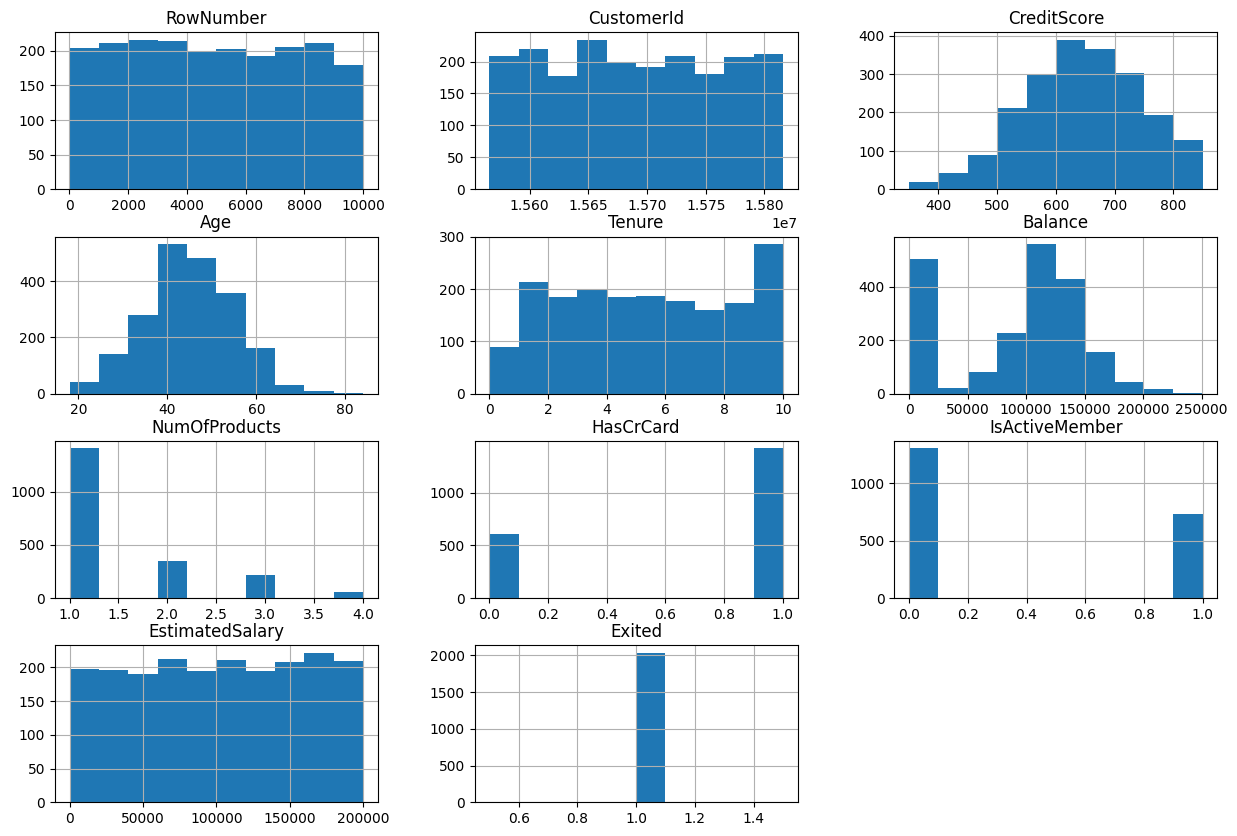

In [4]:
data[data['Exited'] == 1].hist(figsize=(15,10));

В строках с пропусками присуствую данные клиентов с различными кредитными рейтингами, балансами счёта и расчётными зарплатами, примерно такая же ситуация у клиентов, которые покинули банк, а гистограмма со сроками пребывания клиентами в банке равномерна и не имеет выраженных пиков, поэтому заполним пропуски случайными значениями из тех, что уже встречаются. 

In [5]:
data.loc[data['Tenure'].isna(), 'Tenure'] = np.random.randint(0, 10)

## Исследование задачи

Стоблцы 'RowNumber', 'CustomerId', 'Surname' используются для идентификации клиента, но не помогут спрогнозировать останется ли этот клиент в будущем, поэтому удалим эти столбцы из датасета.

In [6]:
data_cleared = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
#sns.pairplot(data_cleared, hue="Exited")

Разбьём данные на обучающую, валидационную и тестовые выборки, а затем закодируем строковые данные в стобцах датасета с помощью OHE.

In [7]:
target = data_cleared['Exited']
features = data_cleared.drop('Exited', axis=1)

features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.2)

features_train, features_valid, target_train, target_valid = \
train_test_split(features_train, target_train, test_size=0.25)

samples = [features_train, features_valid, features_test, target_train, target_valid, target_test]
samples_names = ['features_train', 'features_valid', 'features_test', 'target_train', 'target_valid', 'target_test']

for i in range(len(samples)):
    print(samples_names[i], samples[i].shape)

features_train (6000, 10)
features_valid (2000, 10)
features_test (2000, 10)
target_train (6000,)
target_valid (2000,)
target_test (2000,)


In [8]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_valid = pd.get_dummies(features_valid, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

Для начала проверим эффективность baseline модели.

In [9]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=1)\
.fit(features_train, target_train)
target_predicted = dummy_model.predict(features_valid)

f1_score(target_valid, target_predicted)

0.0

Baseline модель показала нулевую эффективность, посмотрим на результаты модели логистической  регрессии и решающего дерева с несбалансированными классами.

In [10]:
model = LogisticRegression().fit(features_train, target_train)
target_predicted = model.predict(features_valid)

f1_score(target_valid, target_predicted)

0.08352668213457076

In [11]:
model = DecisionTreeClassifier().fit(features_train, target_train)
target_predicted = model.predict(features_valid)

f1_score(target_valid, target_predicted)

0.452020202020202

Обе модели не показывают значения метриики на целевом уровне.

## Борьба с дисбалансом

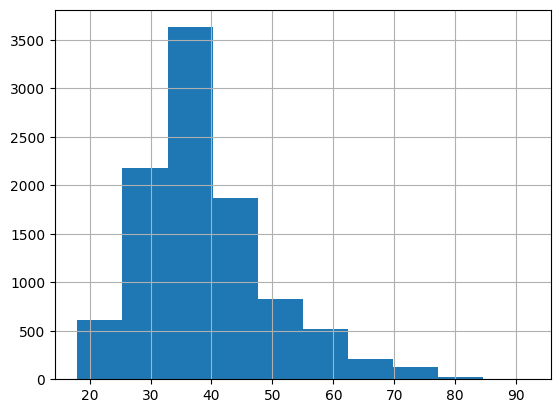

In [12]:
data['Age'].hist() ;

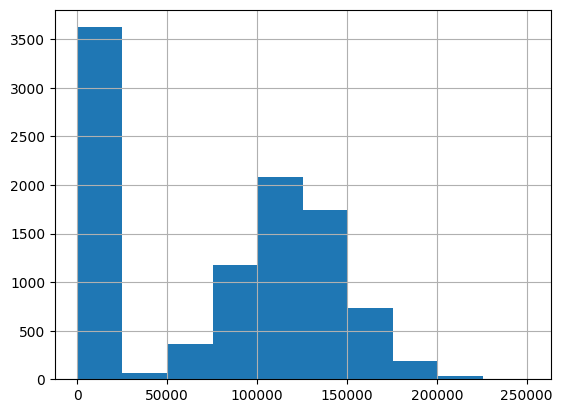

In [13]:
data['Balance'].hist() ;

На примере стобцов 'Age' и 'Balance' видно, что значения в них очень сильно отличаются, поэтому необходимо стандартитизировать признаки во всех выборках.

In [14]:
pd.options.mode.chained_assignment = None

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male']

scaler = StandardScaler().fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Посморим как изменилась метрика модели после масштабирования признаков.

In [15]:
model = LogisticRegression().fit(features_train, target_train)
target_predicted = model.predict(features_valid)

f1_score(target_valid, target_predicted)

0.2740286298568507

In [16]:
data['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

В изначальной выборке клиентов, которые покинули банк в 4 раза меньше чем тех, кто остался, посмотрим как повлияет увеличение количество данных с целевым признаком 1 на качество обучения модели. 

In [17]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)


In [18]:
model = LogisticRegression().fit(features_upsampled, target_upsampled)
target_predicted = model.predict(features_valid)

f1_score(target_valid, target_predicted)

0.48490230905861453

Модель значительно прибавила в качестве, теперь подберём гиперпараметры для модели случайного леса.

In [19]:
%%time

best_score = 0
best_depth = None
best_model = None

t_start = perf_counter()

for depth in range(1, 101):
    
    model = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=8)\
    .fit(features_upsampled, target_upsampled)
    t_stop = perf_counter()
    if t_stop - t_start > 5:
        break
    score = f1_score(target_valid, model.predict(features_valid))
    if score > best_score:
        best_score = score
        best_depth = depth
        best_model = model
        
print('F1-метрика модели', best_score)
print('Глубина модели', best_depth)

F1-метрика модели 0.5995475113122172
Глубина модели 8
CPU times: user 5.03 s, sys: 7.26 ms, total: 5.04 s
Wall time: 5.04 s


In [20]:
%%time

best_score = 0
best_est = None

t_start = perf_counter()

for est in range(10, 1001):
    
    
    model = RandomForestClassifier(n_estimators=est, max_depth=best_depth, random_state=10)\
    .fit(features_upsampled, target_upsampled)
    t_stop = perf_counter()
    
    if t_stop - t_start > 30:
        break
    
    score = f1_score(target_valid, model.predict(features_valid))
    
    if score > best_score:
        
        best_score = score
        best_est = est
        best_model = model

print('F1-метрика модели', best_score)
print('Глубина модели', best_depth)
print('Количество деревьев', best_est)

F1-метрика модели 0.6002265005662514
Глубина модели 8
Количество деревьев 79
CPU times: user 30.1 s, sys: 0 ns, total: 30.1 s
Wall time: 30.1 s


Получили, что наилучший результат показывает модель случайного леса с грубиной 22 и количество деревьев 32.

## Тестирование модели

Проверим результаты лучшей модели на тестовой выборке.

In [21]:
f1_score(target_test, best_model.predict(features_test))

0.6272545090180361

Модель показывает значение метрики на целевом уровне.

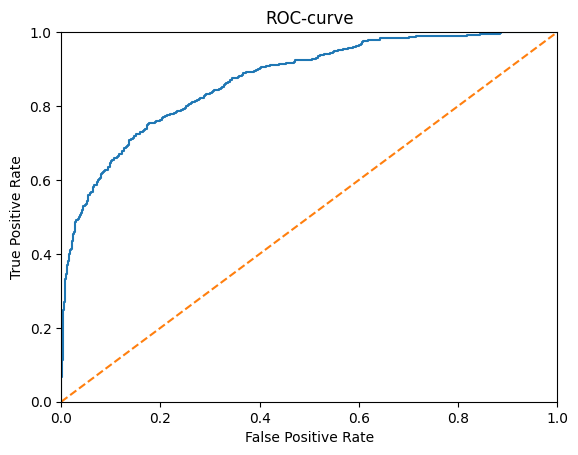

In [22]:
probabilities_valid = best_model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

In [23]:
roc_auc_score(target_test, probabilities_one_valid)

0.8712429094351437

Метрики демонстрируют, что модель обучена на хорошем уровне.

## Выводы по проделанной работе
Целью данного исследования было составление модели, прогнозирующей отток клиентов из банка на основе исторических данных. Для этого были выполнены следующие действия:
1. Устранены пропуски с информацией в стобце 'Tenure', информация была дополнена медианными значениями.
1. Из датасета были удалены идентификационные признаки клиентов, не влияющие на обучение модели, а оставшиеся строковые признаки были закодированы.
1. Рассчитаны эффективности baseline модели и модели с несбалансированными признаками, они оказалась не достаточными.
1. Для улучшения обучения модели обучающаю выборка была расширена данными с положительными целевыми признаками.
1. Был произведён рассчёт гиперпараметров наилучшей модели случайного леса.

В результате, на тестовой выборке полученная модель показала значения f1-метрики на целевом уровне, также с помощью AUC-ROC метрики было показано, что модель хорошо обучена.